In [59]:
import gym
import math
import random
import numpy as np
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [61]:
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [5]:
state = env.reset()

In [11]:
random.randint(0,1)

0

In [46]:
flag = 0
env.reset()
while True:
    state,reward,done,_ = env.step(random.randint(0,1))
    if done:
        state = None
        flag = 1
    if state is not None:    
        print(state,reward,done)
    if flag==1:
        break
  

[-0.03766803 -0.18497433 -0.00271551  0.31925608] 1.0 False
[-0.04136751 -0.3800575   0.00366962  0.61108141] 1.0 False
[-0.04896866 -0.57523055  0.01589124  0.90491787] 1.0 False
[-0.06047328 -0.38032737  0.0339896   0.61727185] 1.0 False
[-0.06807982 -0.18569632  0.04633504  0.33548491] 1.0 False
[-0.07179375  0.00873663  0.05304474  0.05776613] 1.0 False
[-0.07161902 -0.18710418  0.05420006  0.366702  ] 1.0 False
[-0.0753611  -0.38295275  0.0615341   0.67597048] 1.0 False
[-0.08302016 -0.57887334  0.07505351  0.98737477] 1.0 False
[-0.09459762 -0.77491566  0.094801    1.30265542] 1.0 False
[-0.11009594 -0.58111551  0.12085411  1.04109029] 1.0 False
[-0.12171825 -0.77761739  0.14167592  1.36913787] 1.0 False
[-0.13727059 -0.58452367  0.16905868  1.12391279] 1.0 False
[-0.14896107 -0.78140905  0.19153693  1.46449736] 1.0 False


In [196]:
class ReplayMemory:
    def __init__(self,capacity):
        self.capacity = capacity
        self.memory = []
    
    def push(self,transition):
        if len(self.memory)<self.capacity:
            self.memory.append(transition)
        else:
            self.memory = self.memory[:-1]
            self.memory = [transition] + self.memory
            
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def memoryLength(self):
        return len(self.memory)

In [203]:
# cartpole game has two discrete actions. Our module which tries to estimate the Q-function takes the state as input
# outputs estimates of Q(state, left) and Q(state, right)
# we use two-layer feed forward network here...(this ofcourse is not the best choice but good enough for our understanding)

class DQN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DQN, self).__init__()
        
        self.i2h = nn.Linear(input_size,hidden_size)
        self.h2h = nn.Linear(hidden_size,hidden_size)
        self.h2o = nn.Linear(hidden_size,output_size)

    def forward(self, input):
        output = self.i2h(input)
        output = self.h2h(output)
        output = self.h2o(output)
        return output

In [204]:
q_net = DQN(4,25,2)
v_net = DQN(4,25,2)

In [205]:
steps_done = 0
transition = namedtuple('transition','state next_state reward action')
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

def select_action(q_net,state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            #print(state)
            #print(q_net(state))
            return q_net(state).max(1)[1].item()
    else:
        return random.randrange(2)

In [206]:
v_net = DQN(4,25,2)
v_net.load_state_dict(q_net.state_dict())

In [207]:
optimizer = optim.RMSprop(q_net.parameters())
memory = ReplayMemory(10000)

In [208]:
BATCH_SIZE = 128
def optimize_model():
    if memory.memoryLength() < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    #print(len(transitions))
    # gather all non-final transistion
    n_f_transitions = list(filter(lambda x:x.next_state is not None,transitions))
    #[s for s in transitions and s.next_state is None]
    rewards = torch.tensor([s.reward.item() for s in n_f_transitions]).view(-1,1)
    batch_states = torch.cat([s.state for s in n_f_transitions],0)
    batch_next_states = torch.cat([s.next_state for s in n_f_transitions],0)
    batch_actions = torch.tensor([s.action for s in n_f_transitions]).view(-1,1)
    
    # obtain the expected q-net value
    q_net_val = q_net(batch_states).gather(1,batch_actions)
    
    # obtain the q-net value
    v_net_val = v_net(batch_next_states).max(1)[0].view(-1,1)
    v_net_val = GAMMA*v_net_val + rewards
    
    
    loss = F.smooth_l1_loss(q_net_val, v_net_val.detach())
    #print("loss",loss)
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    

In [209]:
episode_durations = []
num_episodes = 1000
for i_episode in range(num_episodes):
    curr_state = env.reset()
    for t in count():
        c_s_tensor = torch.from_numpy(curr_state).float().view(1,4)
        action = select_action(q_net,c_s_tensor)
        next_state, reward, done, _ = env.step(action)
        reward = torch.tensor([reward])
        
        if done:
            next_state = None

        # Store the transition in memory
        if next_state is not None:
            n_s_tensor = torch.from_numpy(next_state).float().view(1,4)
        else:
            n_s_tensor = None
        #print(reward)    
        #r_tensor = torch.from_numpy(reward).float().view(1,1)
        memory.push(transition(state=c_s_tensor, action=action, next_state=n_s_tensor, reward=reward))

        # Move to the next state
        curr_state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            break
    if i_episode % 100 ==0:
        print(episode_durations[i_episode])
    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        v_net.load_state_dict(q_net.state_dict())

print('Complete')
env.close()

27
8
9
9
9
10
8
10
10
9
Complete


In [115]:
import matplotlib.pyplot as plt

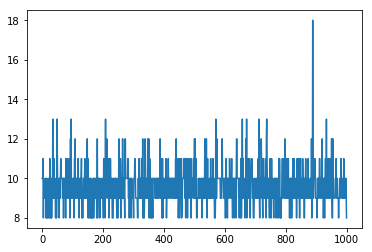

In [121]:
plt.plot(episode_durations)